# Formula 1 Statistics

# 0. Introduction


Formula 1 is the most global motorsport. One of the things that seperates F1 from every other sport is that there is no even playing field. Teams set out to build the fastest car possible within the rules (and bending the rules when able), which generally mean that the team with the most money builds the fastest car. Take for example, mercedes. Mercedes have dominated the sport since the last rules overhaul in 2014 and sell engines to other teams. The most striking highlight of this is the face that williams (currently one of the slowest teams on the grid) and mercedes (the most dominate team) use the same engines. The difference comes from how much more money Mercedes is able to throw at aerodynamic development. Also mention the example of George Russell almost winning in the Mercedes when he was borrowed from Williams. 

This makes any meaningful discussion of the quality between drivers incredibly difficult. Entire blogs and research papers from the statistics community have been dedicated disconnecting driver performance from car performance([f1 metrics blog](https://f1metrics.wordpress.com/), Find some actual research papers in math that I have encountered). 

In this write-up, I don't expect to definitevly answer that question. However, I would like to play around with the stats a little, and see if I can come up with some ways of my own to approach this question. 

I will evaluate a few key metrics
- distribution of lap times over a race and the "spread of spreads" of lap times over a season
- teammate head-to-head

- highlight some key findings
In this notebook, we explore the F1 dataset on [kaggle](https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020) using SQL.  

In [4]:
# basics
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Sql stuff
from psycopg2 import connect, extensions, sql
#from IPython.display import clear_output

# other
from datetime import datetime, time, date
from collections import defaultdict

# Load login info for postgres. 

with open("postgres_login_info.txt") as f: 
    login_info = f.read()
mpl.rcParams['figure.max_open_warning'] = 50

First, we will define a function to query the database. 

In [5]:
def query(text):
    """Run a query on the Formula_1_statistics database using the text input
    Parameters
    ---------
    text: SQL code to run
    
    Returns
    ---------
    df: DataFrame containing the result of the submitted query
    
    """
    with connect(login_info) as conn, conn.cursor() as cur:  
        autocommit = extensions.ISOLATION_LEVEL_AUTOCOMMIT
        conn.set_isolation_level(autocommit)
        
        query = sql.SQL(text)
        cur.execute(query)
        return pd.DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

For plotting, define a few dictionaries for team colors and abreviations. At a future update I would like to make this into a seperate table with team name, color, an year to accommodate livery changes through the years. 

In [6]:
colors = defaultdict(lambda: '#FFFFFF', {
                     'Mercedes'      : '#00D2BE', 
                     'Ferrari'       : '#C00000', 
                     'Red Bull'      : '#0600EF', 
                     'Renault'       : '#FFF500', 
                     'Haas F1 Team'  : '#787878', 
                     'Racing Point'  : '#F596C8', 
                     'Force India'   : '#F596C8', 
                     'AlphaTauri'    : '#C8C8C8',
                     'Toro Rosso'    : '#469BFF',
                     'McLaren'       : '#FF8700', 
                     'Alfa Romeo'    : '#960000',
                     'Sauber'        : '#960000',
                     'Williams'      : '#0082FA', 
                     'Lotus F1'      : '#FFB800',
                     'Manor Marussia': '#6E0000'
                    })

team_abbrev = defaultdict(lambda: 'NA', {
                     'Mercedes'      : 'Merc', 
                     'Ferrari'       : 'Fer', 
                     'Red Bull'      : 'RB', 
                     'Renault'       : 'Ren', 
                     'Haas F1 Team'  : 'Has', 
                     'Racing Point'  : 'RP', 
                     'Force India'   : 'FI', 
                     'AlphaTauri'    : 'AT', 
                     'Toro Rosso'    : 'TR', 
                     'McLaren'       : 'McL', 
                     'Alfa Romeo'    : 'AR', 
                     'Sauber'        : 'Sau', 
                     'Williams'      : 'Wil',
                     'Lotus F1'      : 'Lot', 
                     'Manor Marussia': 'MM'
                    })

# 1. Lap distributions

## 1.1 Queries

Write a query that will get the lap times for one driver over the course of 1 race. These laps may be filtered by a multiple of the average lap time to remove safety car periods and pit stops. 

In [224]:
def get_lap_distribution(firstname=None, lastname=None, driverref=None, race=None, year=None, cutoff=1.2, 
                         filter_laps=False):
    """Query the database to get the lap time distribution for 1 driver over the course of 1 race. 
    
    Parameters 
    ---------
    firstname: string
        driver's first name
    lastname: string
        driver's last name
    driverref: string
        driver reference- can substitute for first name and last name (e.g. pass driverref="HAM" instead of 
        firstname="Lewis", lastname="Hamilton")
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
    cutoff: float > 1
        will remove lap times longer than cutoff * average lap time
    filter_laps: boolean
        Currently unused. Whether or not to filter laps using cutoff. For now, use cutoff=10 to include all laps. 
    """
    
    
    text = f"""
    
    -- Get a list of lap times for the specific race
    WITH times AS (SELECT EXTRACT(MINUTES FROM lap_times.time)*60 +
                            EXTRACT(SECONDS FROM lap_times.time) AS lap_time, 
                        lap_times.lap, 
                        lap_times.position, 
                        lap_times.driverid, 
                        lap_times.raceid,
                        EXTRACT(YEAR FROM races.date) AS year
                 FROM lap_times 
                 JOIN races ON lap_times.raceid = races.raceid 
                 JOIN circuits ON races.circuitid = circuits.circuitid
                 WHERE ((races.name iLike '%{race}%') AND year = {year})
                 ),
   
   -- Get the pit stops. 
    pits AS (SELECT pit_stops.driverid, 
                    pit_stops.raceid, 
                    pit_stops.stop, 
                    pit_stops.lap AS pit_lap, 
                    pit_stops.time, 
                    pit_stops.duration
             FROM pit_stops
             JOIN races ON pit_stops.raceid = races.raceid
             JOIN drivers ON pit_stops.driverid = drivers.driverid
             WHERE(
                  (races.name iLike '%{race}%') 
                   AND year = {year}
                   AND ((drivers.forename iLike '%{firstname}%'
                       AND drivers.surname iLike '%{lastname}%') 
                        OR drivers.driverref iLike '%{driverref}%')
                  )
    ), 
    
    average_lap AS (SELECT AVG(times.lap_time) AS time FROM times) 
              
              
    SELECT lap_times.lap,
           CASE 
               WHEN (EXTRACT(MINUTES FROM lap_times.time)*60 + EXTRACT(SECONDS FROM lap_times.time) 
               > {cutoff} * (SELECT average_lap.time FROM average_lap)) THEN NULL 
               ELSE (EXTRACT(MINUTES FROM lap_times.time)*60 + EXTRACT(SECONDS FROM lap_times.time)) 
           END AS lap_time,
           CASE
               WHEN lap_times.lap IN (SELECT pits.pit_lap FROM pits) THEN TRUE
               ELSE FALSE
            END AS pit_lap, 
           lap_times.position,
           drivers.forename, 
           drivers.surname, 
           drivers.code, 
           races.name, 
           races.year, 
           status.status
    FROM lap_times
    
    JOIN drivers ON drivers.driverid = lap_times.driverid
    JOIN races ON races.raceid = lap_times.raceid
    JOIN results ON results.raceid = lap_times.raceid
    JOIN status ON results.statusid = status.statusid
    
    WHERE(
        
        -- filter drivers
        ((drivers.forename iLike '%{firstname}%'
        AND drivers.surname iLike '%{lastname}%')
        OR drivers.driverref iLike '%{driverref}%')
        
        -- filter results
        AND results.driverid = (
                SELECT driverid
                FROM drivers
                WHERE ((drivers.forename iLike '%{firstname}%'
                        AND drivers.surname iLike '%{lastname}%')
                        OR drivers.driverref iLike '%{driverref}%')
                LIMIT 1
                )

        -- filter races
        AND races.name iLike '%{race}%' AND races.year = {year}
    ) 
    """
    
    
    return query(text)

def get_race_distribution(race, year, cutoff=1.2, skip_cut_laps=False):
    """Query a dataframe to get the lap times of every driver on the grid over the course of a race"""
    
    text = f"""

    SELECT drivers.forename AS firstname,
           drivers.surname AS lastname,
           drivers.code, 
           drivers.driverid, 
           drivers.driverref,
           results.positionorder,
           races.name AS race_name, 
           constructors.name AS team
    FROM drivers
    JOIN results ON results.driverid = drivers.driverid
    JOIN races ON races.raceid = results.raceid
    JOIN constructors ON constructors.constructorid = results.constructorid
    WHERE races.year = {year} AND races.name iLike '%{race}%'
    """
    
    drivers_df =  query(text);
    frames = [get_lap_distribution(driverref=ref, race=race, year=year, cutoff=cutoff) 
              for ref in drivers_df['driverref']];
    lap_time_results = pd.concat(frames).sort_values(by="lap_time")
    lap_time_results['team'] = [drivers_df[drivers_df['code'] == i]['team'].values[0] for i in lap_time_results['code']]
    
    return lap_time_results.sort_values(by="position")

In [230]:
get_lap_distribution(driverref="HAM", race="British", year=2020).head()

lap  lap_time  pit_lap  position forename   surname code  \
0    1     94.01    False         1    Lewis  Hamilton  HAM   
1    2       NaN    False         1    Lewis  Hamilton  HAM   
2    3       NaN    False         1    Lewis  Hamilton  HAM   
3    4       NaN    False         1    Lewis  Hamilton  HAM   
4    5       NaN    False         1    Lewis  Hamilton  HAM   

                 name  year    status  
0  British Grand Prix  2020  Finished  
1  British Grand Prix  2020  Finished  
2  British Grand Prix  2020  Finished  
3  British Grand Prix  2020  Finished  
4  British Grand Prix  2020  Finished

In [228]:
get_race_distribution(race="British", year=2020)

lap  lap_time pit_lap position   forename   surname code  \
31  32    89.995   False        1      Lewis  Hamilton  HAM   
37  38    89.553   False        1      Lewis  Hamilton  HAM   
8    9    90.868   False        1      Lewis  Hamilton  HAM   
4    5       NaN   False        1      Lewis  Hamilton  HAM   
30  31    89.660   False        1      Lewis  Hamilton  HAM   
..  ..       ...     ...      ...        ...       ...  ...   
10  10    92.208   False       18  Alexander     Albon  ALB   
5    5   122.869   False       18   Nicholas    Latifi  LAT   
9    9    92.407   False       18  Alexander     Albon  ALB   
7    7   114.670   False       18  Alexander     Albon  ALB   
1    1   105.776   False       19   Nicholas    Latifi  LAT   

                  name  year    status      team  
31  British Grand Prix  2020  Finished  Mercedes  
37  British Grand Prix  2020  Finished  Mercedes  
8   British Grand Prix  2020  Finished  Mercedes  
4   British Grand Prix  2020  Finished  Mercedes  
30  British Grand Prix  2020  Finished  Mercedes  
..                 ...   ...       ...       ...  
10  British Grand Prix  2020  Finished  Red Bull  
5   British Grand Prix  2020  Finished  Williams  
9   British Grand Prix  2020  Finished  Red Bull  
7   British Grand Prix  2020  Finished  Red Bull  
1   British Grand Prix  2020  Finished  Williams  

[895 rows x 11 columns]

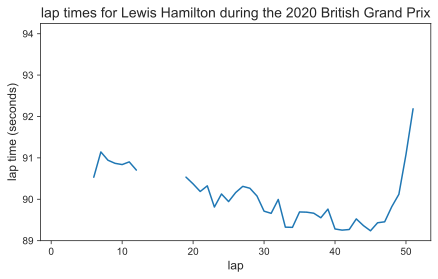

In [265]:
# Delete this after debugging

def plot_laps(firstname=None, lastname=None, driverref=None, race=None, year=None, cutoff=1.2, skip_cut_laps=True, 
              ax=None):
    """Plot lap times for 1 driver over the course of 1 race, leaving gaps for safety cars and pit stops."""
    df = get_lap_distribution(firstname=firstname, lastname=lastname, driverref=driverref, race=race, year=year,
                             cutoff=cutoff)
    if ax == None: 
        fig, ax = plt.subplots(figsize=[7, 4])
    if skip_cut_laps: 
        lap_times = np.where(df.lap_time.isnull(), None, df['lap_time'])
    else: 
        lap_times = df['lap_times']
    plt.plot(df["lap"].to_numpy(), lap_times)
    #else: 
        #sns.lineplot(x=df["lap"].to_numpy(), y=df['lap_times'])
    
    
    # the following raises DataError: No numeric types to aggregate. Not sure why it works wit plt but not sns
    # sns.lineplot(x=df["lap"].to_numpy(), y=np.where(df.lap_time.isnull(), None, df['lap_time']), ax=ax) 
    
    first_name = df['forename'].values[0]
    last_name = df['surname'].values[0]
    race_name = df['name'].values[0]
    ax.set_title(f"lap times for {first_name} {last_name} during the {year} {race_name}", fontsize=14)
    ax.set_xlabel("lap", fontsize=12)
    ax.set_ylabel("lap time (seconds)", fontsize=12);
    
plot_laps(driverref="HAM", race="British", year=2020, cutoff=1.1, skip_cut_laps=True)

Delete this section later

>It appears that nothing is plotting for the first 5 laps of the race- this is due to the fact that the first lap is usually slow and a safety car on the second lap. Also note the safety car on lap 13. The longer time on the last lap is due to Hamilton's tyre failure on the last lap ([source](https://www.youtube.com/watch?v=HmEsqWosuS8&ab_channel=FORMULA1))

## TODO: make 10 plots, one for each pair of teammates and compare their lap times head-to-head - done

## TODO: make a plot of the deltas between teammates

## TODO: make a plot of the distribution of deltas (divided by average lap time) over all the races to directly compare teammates

Now get the lap times for every driver over the course of a race. 

In [133]:
df[df['code']=='KVY']

lap  lap_time pit_lap position forename surname code                name  \
10  11    92.443   False       12   Daniil   Kvyat  KVY  British Grand Prix   
6    7    94.402   False       13   Daniil   Kvyat  KVY  British Grand Prix   
7    8    93.521   False       13   Daniil   Kvyat  KVY  British Grand Prix   
9   10    93.461   False       13   Daniil   Kvyat  KVY  British Grand Prix   
8    9    93.384   False       13   Daniil   Kvyat  KVY  British Grand Prix   
3    4   155.038   False       14   Daniil   Kvyat  KVY  British Grand Prix   
0    1   103.748   False       14   Daniil   Kvyat  KVY  British Grand Prix   
2    3   149.324   False       14   Daniil   Kvyat  KVY  British Grand Prix   
1    2   135.827   False       14   Daniil   Kvyat  KVY  British Grand Prix   
4    5   126.770   False       14   Daniil   Kvyat  KVY  British Grand Prix   
5    6    94.683   False       14   Daniil   Kvyat  KVY  British Grand Prix   

    year    status        team  
10  2020  Accident  AlphaTauri  
6   2020  Accident  AlphaTauri  
7   2020  Accident  AlphaTauri  
9   2020  Accident  AlphaTauri  
8   2020  Accident  AlphaTauri  
3   2020  Accident  AlphaTauri  
0   2020  Accident  AlphaTauri  
2   2020  Accident  AlphaTauri  
1   2020  Accident  AlphaTauri  
4   2020  Accident  AlphaTauri  
5   2020  Accident  AlphaTauri

## 1.2 Plots

## Make race traces for the given race

In [146]:
def plot_race_trace(race=None, year=None, cutoff=10): 
    """Function to plot the race traces. """
    
    # edit: use median lap time? 
    df = get_race_distribution(race=race, year=year, cutoff=cutoff)
    laps = df['lap'].sort_values().unique()
    avg_time = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])

    
    fig, ax = plt.subplots(figsize=[20, 10])
    for driver in df['code'].unique(): 
        deltas = [ (df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)] - avg_time[lap - 1]).values[0]
                  for lap in laps if len(df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)]) > 0 ]
        plt.plot(deltas, color=colors[df['team'][df['code']==driver].values[0]])

#### TODO: FORMAT PLOTS

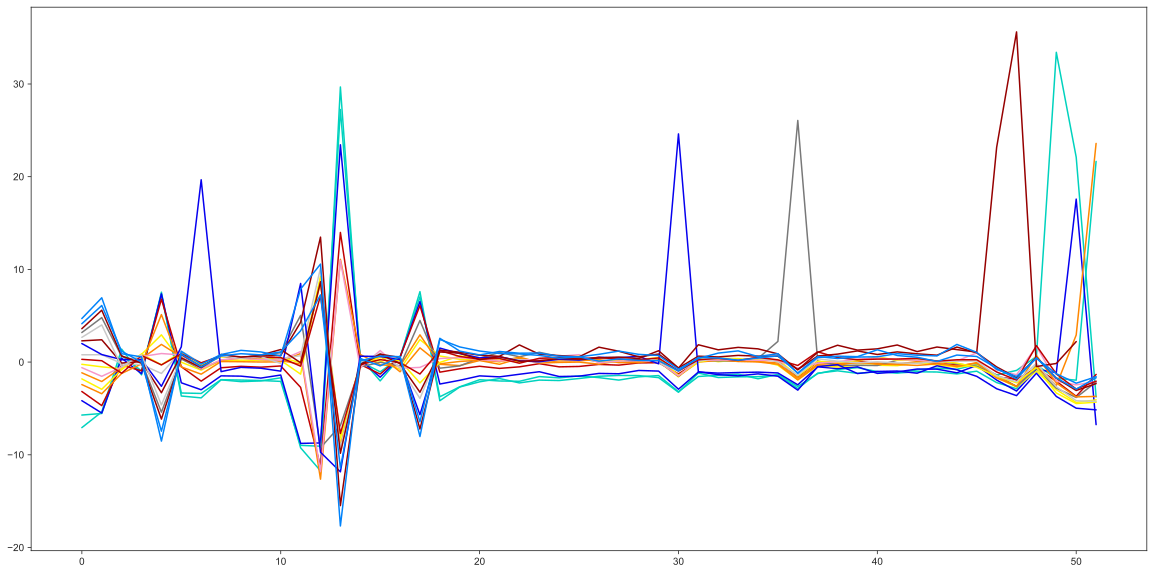

In [147]:
plot_race_trace(race="British", year=2020)

In [166]:
def plot_team_trace(race=None, year=None, cutoff=10): 
    
    df = get_race_distribution(race=race, year=year, cutoff=cutoff)
    fig, ax = plt.subplots(nrows=len(df['team'].unique()), figsize=[10, 20])
    
    laps = df['lap'].sort_values().unique()
    avg_time = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])
    
    for index, team in pd.Series(df['team'].unique()).items():
        for driver in df['code'][df['team']==team].unique():
            deltas = [ (df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)] - avg_time[lap - 1]).values[0]
                      for lap in laps if len(df['lap_time'][(df['code'] == driver) & (df['lap'] == lap)]) > 0 ]
            ax[index].plot(deltas, color=colors[df['team'][df['code']==driver].values[0]])
        

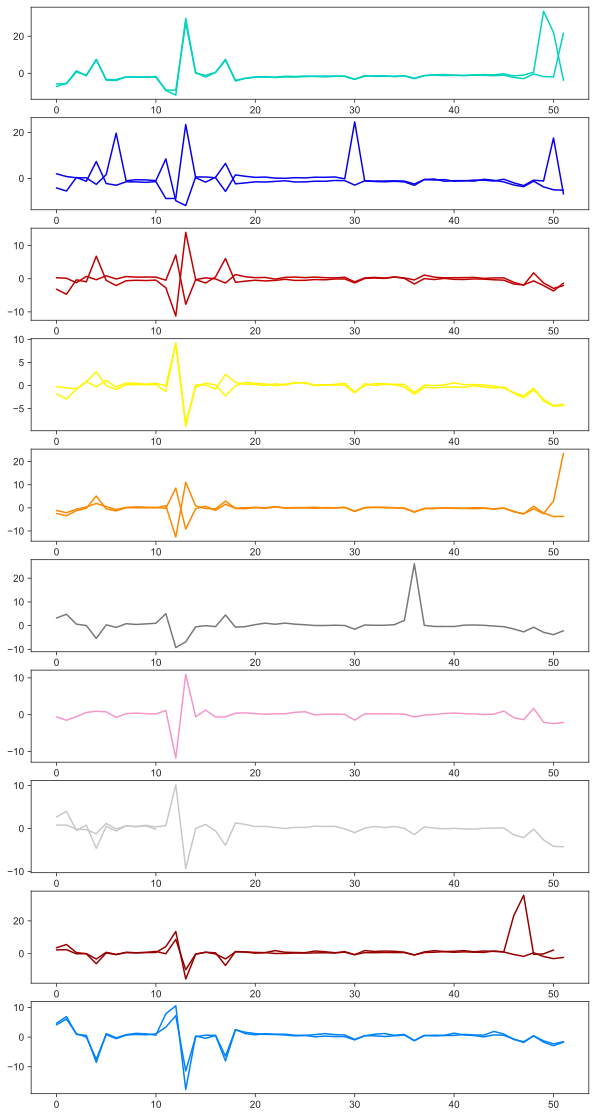

In [167]:
plot_team_trace(race="British", year=2020)

# 2. Distribution of lap times

# 2.1 untitled subsection

One of the ways to measure the quality of a driver is by their consistency. And one of the ways to measure consistency is to study the distribution of lap times during a race. To do that, we can use the coefficient of variaiton ($\frac{\sigma}{\mu}$) which is a way to measure the variances of sample distirbutions with different means. 

Make a plot of all the lap distributions for a race with violin plots. Previously, this was done with box plots. The option to use box plots will likely be deleted in another update

In [307]:
def get_finishing_order(race, year):
    results_text = f"""
    SELECT results.positionorder, 
           drivers.code
    FROM results
    JOIN races ON races.raceid = results.raceid
    JOIN drivers ON drivers.driverid = results.driverid
    WHERE races.year = {year} AND races.name iLike '%{race}%' 
    
    ORDER BY results.positionorder
    """
    results_df = query(results_text); 
    return results_df

def plot_race_distribution(race, year, outliers=False, whis=1.5, cutoff=1.2, colors=colors, bw=1.2): 
    """Plot the distribution of lap times over the course of a race"""
    
    df = get_race_distribution(race=race, year=year, cutoff=cutoff);
 
    fastest_lap = df['lap_time'].min()
    slowest_lap = df['lap_time'].max()
    
    # get the finishing order
    finishing_order = get_finishing_order(race=race, year=year)['code'].to_numpy()
    
    sns.set_style("ticks")
    
    %config InlineBackend.figure_format = 'svg'
    
    # filter out the non-finishers
    accepted_statuses = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps']
    #df_predrop = df
    #df = df.drop(df[~df['status'].isin(accepted_statuses)].index)
    
    fig, ax = plt.subplots(figsize=[9, 4])
    
    # make plots
    sns.violinplot(ax=ax, 
                   data=df, 
                   y="lap_time", 
                   x="code", 
                   hue="team", 
                   palette=colors, 
                   order=finishing_order, 
                   showfliers=outliers,
                   dodge=False, 
                   #inner="stick",
                   bw=bw
                  )
    ax.legend(bbox_to_anchor=(1,1),
              loc='upper left',
              ncol=1,  
              fontsize=12)

    ax.set_xlabel("driver", fontsize=12)
    ax.set_ylabel("lap time (seconds)", fontsize=12),
    ax.set_ylim([(fastest_lap-0.5), fastest_lap*(cutoff)+2])
    ax.tick_params(labelsize=10)
    ax.autoscale(enable=True)
    ax.set_title(f"Lap time distribution for the {year} {df['name'].values[0]}\n", fontsize=15)
    return ax, df#, df_predrop

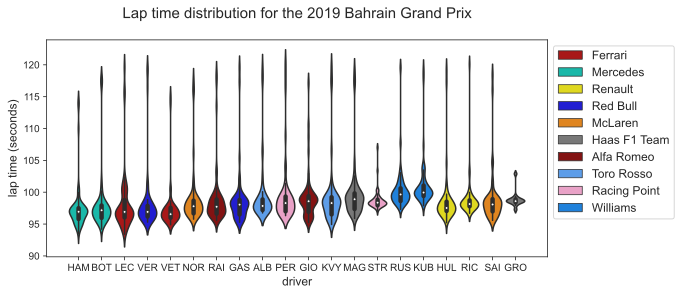

In [302]:
_, df, df2 = plot_race_distribution(race="Bahrain", year=2019, cutoff=1.2, bw=0.2);

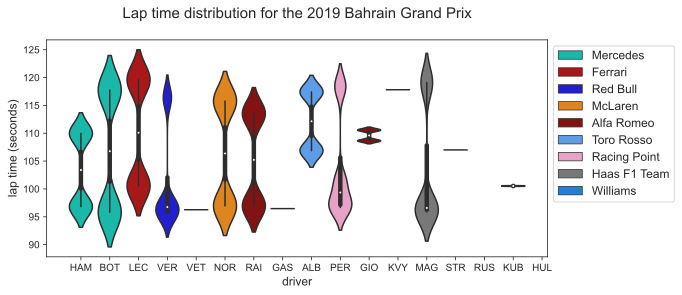

In [305]:
_, df, df2 = plot_race_distribution(race="Bahrain", year=2019, cutoff=1.2, bw=0.2);

In [294]:
df[df['code']=="GAS"]

lap  lap_time  pit_lap  position forename surname code  \
54   35    98.849    False         6   Pierre   Gasly  GAS   
55   36    98.676    False         6   Pierre   Gasly  GAS   
56   37    98.533    False         6   Pierre   Gasly  GAS   
53   34    98.406    False         7   Pierre   Gasly  GAS   

                  name  year    status      team  
54  Bahrain Grand Prix  2019  Finished  Red Bull  
55  Bahrain Grand Prix  2019  Finished  Red Bull  
56  Bahrain Grand Prix  2019  Finished  Red Bull  
53  Bahrain Grand Prix  2019  Finished  Red Bull

In [299]:
accepted_statuses = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps']

In [300]:
df2

lap  lap_time  pit_lap  position forename   surname code  \
37   38    93.411    False         1  Charles   Leclerc  LEC   
20   21    95.988    False         1  Charles   Leclerc  LEC   
31   32    97.167    False         1  Charles   Leclerc  LEC   
10   11    97.193    False         1  Charles   Leclerc  LEC   
8     9    97.205    False         1  Charles   Leclerc  LEC   
..  ...       ...      ...       ...      ...       ...  ...   
5     6    95.842    False        20   Carlos     Sainz  SAI   
8     9    97.523    False        20   Carlos     Sainz  SAI   
9    10    97.275    False        20   Carlos     Sainz  SAI   
14   15    98.616    False        20   Carlos     Sainz  SAI   
1     2       NaN    False        20   Romain  Grosjean  GRO   

                  name  year            status          team  
37  Bahrain Grand Prix  2019          Finished       Ferrari  
20  Bahrain Grand Prix  2019          Finished       Ferrari  
31  Bahrain Grand Prix  2019          Finished       Ferrari  
10  Bahrain Grand Prix  2019          Finished       Ferrari  
8   Bahrain Grand Prix  2019          Finished       Ferrari  
..                 ...   ...               ...           ...  
5   Bahrain Grand Prix  2019  Collision damage       McLaren  
8   Bahrain Grand Prix  2019  Collision damage       McLaren  
9   Bahrain Grand Prix  2019  Collision damage       McLaren  
14  Bahrain Grand Prix  2019  Collision damage       McLaren  
1   Bahrain Grand Prix  2019           Retired  Haas F1 Team  

[1081 rows x 11 columns]

In [298]:
df_test = df2

lap  lap_time  pit_lap  position forename surname code  \
2    39   101.894     True         5   Pierre   Gasly  GAS   
54   35    98.849    False         6   Pierre   Gasly  GAS   
55   36    98.676    False         6   Pierre   Gasly  GAS   
56   37    98.533    False         6   Pierre   Gasly  GAS   
1    38    99.175    False         6   Pierre   Gasly  GAS   
52   33    98.807    False         7   Pierre   Gasly  GAS   
53   34    98.406    False         7   Pierre   Gasly  GAS   
20   57       NaN    False         8   Pierre   Gasly  GAS   
17   54    96.470    False         8   Pierre   Gasly  GAS   
19   56       NaN    False         8   Pierre   Gasly  GAS   
18   55       NaN    False         8   Pierre   Gasly  GAS   
46   27    98.060    False         9   Pierre   Gasly  GAS   
45   26    97.960    False         9   Pierre   Gasly  GAS   
51   32    98.353    False         9   Pierre   Gasly  GAS   
49   30    98.402    False         9   Pierre   Gasly  GAS   
48   29    98.197    False         9   Pierre   Gasly  GAS   
47   28    98.752    False         9   Pierre   Gasly  GAS   
44   25    98.019    False         9   Pierre   Gasly  GAS   
50   31    98.689    False         9   Pierre   Gasly  GAS   
16   53    95.865    False         9   Pierre   Gasly  GAS   
15   52    95.755    False         9   Pierre   Gasly  GAS   
8    45    95.524    False        10   Pierre   Gasly  GAS   
9    46    95.390    False        10   Pierre   Gasly  GAS   
10   47    95.671    False        10   Pierre   Gasly  GAS   
13   50    96.062    False        10   Pierre   Gasly  GAS   
12   49    96.248    False        10   Pierre   Gasly  GAS   
14   51    96.708    False        10   Pierre   Gasly  GAS   
11   48    96.211    False        10   Pierre   Gasly  GAS   
42   23    98.429    False        10   Pierre   Gasly  GAS   
7    44    95.949    False        10   Pierre   Gasly  GAS   
43   24    97.965    False        10   Pierre   Gasly  GAS   
41   22    98.087    False        10   Pierre   Gasly  GAS   
5    42    95.291    False        11   Pierre   Gasly  GAS   
23    4   100.003    False        11   Pierre   Gasly  GAS   
25    6    99.343    False        11   Pierre   Gasly  GAS   
37   18    97.473    False        11   Pierre   Gasly  GAS   
4    41    95.444    False        11   Pierre   Gasly  GAS   
36   17    98.070    False        11   Pierre   Gasly  GAS   
40   21    97.623    False        11   Pierre   Gasly  GAS   
3    40   117.320    False        11   Pierre   Gasly  GAS   
24    5    98.574    False        11   Pierre   Gasly  GAS   
6    43    95.780    False        11   Pierre   Gasly  GAS   
38   19    98.052    False        11   Pierre   Gasly  GAS   
39   20    97.681    False        11   Pierre   Gasly  GAS   
21    2    99.116    False        12   Pierre   Gasly  GAS   
0     1   105.321    False        12   Pierre   Gasly  GAS   
27    8    99.189    False        12   Pierre   Gasly  GAS   
22    3    98.794    False        12   Pierre   Gasly  GAS   
26    7   100.112    False        12   Pierre   Gasly  GAS   
33   14    96.567    False        13   Pierre   Gasly  GAS   
34   15    97.667    False        13   Pierre   Gasly  GAS   
35   16    97.565    False        13   Pierre   Gasly  GAS   
28    9   102.197     True        13   Pierre   Gasly  GAS   
32   13    96.819    False        13   Pierre   Gasly  GAS   
31   12    96.493    False        14   Pierre   Gasly  GAS   
29   10   119.647    False        17   Pierre   Gasly  GAS   
30   11    97.179    False        17   Pierre   Gasly  GAS   

                  name  year    status      team  
2   Bahrain Grand Prix  2019  Finished  Red Bull  
54  Bahrain Grand Prix  2019  Finished  Red Bull  
55  Bahrain Grand Prix  2019  Finished  Red Bull  
56  Bahrain Grand Prix  2019  Finished  Red Bull  
1   Bahrain Grand Prix  2019  Finished  Red Bull  
52  Bahrain Grand Prix  2019  Finished  Red Bull  
53  Bahrain Grand Prix  2019  Finished  Red Bull  

Make a plot of all the races in a season for debugging. 

In [254]:
def plot_all_races(year=None, cutoff=1.2, outliers=True, bw=0.2):
    text = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """

    df = query(text)
    return_df = pd.DataFrame()
    for race in df['name']: 
        try: 
            print(race)
            _, df2 = plot_race_distribution(race, year=year, cutoff=cutoff, outliers=outliers, bw=bw)
            print(df2)
            return_df = return_df.append(df2)
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
    return return_df

Australian Grand Prix
    lap  lap_time  pit_lap  position  forename     surname code  \
57   57    85.580    False         1  Valtteri      Bottas  BOT   
1     1    93.813    False         1  Valtteri      Bottas  BOT   
19   19    87.836    False         1  Valtteri      Bottas  BOT   
20   20    87.832    False         1  Valtteri      Bottas  BOT   
4    23    89.025    False         1       Max  Verstappen  VER   
..  ...       ...      ...       ...       ...         ...  ...   
4     4    93.683    False        20    Robert      Kubica  KUB   
8     8    92.346    False        20    Robert      Kubica  KUB   
5     5    93.218    False        20    Robert      Kubica  KUB   
2     3    92.091    False        20    Daniel   Ricciardo  RIC   
0     1       NaN     True        20    Daniel   Ricciardo  RIC   

                     name  year    status      team  
57  Australian Grand Prix  2019  Finished  Mercedes  
1   Australian Grand Prix  2019  Finished  Mercedes  
19  Austral

    lap  lap_time  pit_lap  position   forename   surname code  \
47   48    77.255    False         1  Sebastian    Vettel  VET   
50   51    75.821    False         1  Sebastian    Vettel  VET   
37   38    75.807    False         1  Sebastian    Vettel  VET   
48   27    77.255    False         1      Lewis  Hamilton  HAM   
36   37    75.724    False         1  Sebastian    Vettel  VET   
..  ...       ...      ...       ...        ...       ...  ...   
6     7    78.661    False        20  Alexander     Albon  ALB   
7     8    78.535    False        20  Alexander     Albon  ALB   
1     2    82.732    False        20  Alexander     Albon  ALB   
3     4    79.464    False        20  Alexander     Albon  ALB   
0     1       NaN     True        20  Alexander     Albon  ALB   

                   name  year            status        team  
47  Canadian Grand Prix  2019          Finished     Ferrari  
50  Canadian Grand Prix  2019          Finished     Ferrari  
37  Canadian Grand Pr

no data for Belgian Grand Prix
Neither the `x` nor `y` variable appears to be numeric.
Italian Grand Prix
    lap  lap_time  pit_lap  position   forename     surname code  \
5     6    84.900    False         1    Charles     Leclerc  LEC   
38   39    83.402    False         1    Charles     Leclerc  LEC   
28   29    99.724    False         1    Charles     Leclerc  LEC   
51   52    83.426    False         1    Charles     Leclerc  LEC   
32   24    84.970    False         1   Valtteri      Bottas  BOT   
..  ...       ...      ...       ...        ...         ...  ...   
2     2       NaN    False        20        Max  Verstappen  VER   
14   15    85.179    False        20  Sebastian      Vettel  VET   
3     3    84.532    False        20        Max  Verstappen  VER   
24   25    87.126    False        20     Romain    Grosjean  GRO   
10   11    86.225    False        20     Romain    Grosjean  GRO   

                  name  year    status          team  
5   Italian Grand Prix

    lap  lap_time  pit_lap  position forename     surname code  \
58   13    73.664    False         1      Max  Verstappen  VER   
54   17    73.689    False         1      Max  Verstappen  VER   
62    9    73.683    False         1      Max  Verstappen  VER   
29   43    72.858    False         1      Max  Verstappen  VER   
19   53    72.324    False         1      Max  Verstappen  VER   
..  ...       ...      ...       ...      ...         ...  ...   
47    6    76.577    False        20   George     Russell  RUS   
21   11    74.183    False        20   Daniel   Ricciardo  RIC   
45   44    76.569    False        20   Robert      Kubica  KUB   
51   38    76.807    False        20   Robert      Kubica  KUB   
58   31    75.828    False        20   Robert      Kubica  KUB   

                    name  year    status      team  
58  Brazilian Grand Prix  2019  Finished  Red Bull  
54  Brazilian Grand Prix  2019  Finished  Red Bull  
62  Brazilian Grand Prix  2019  Finished  Red Bu

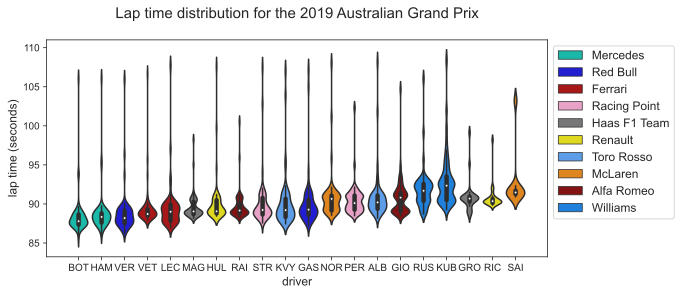

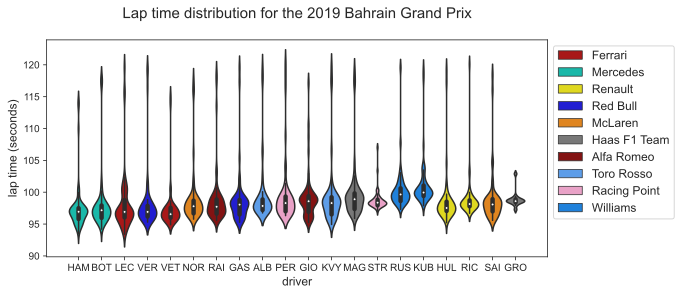

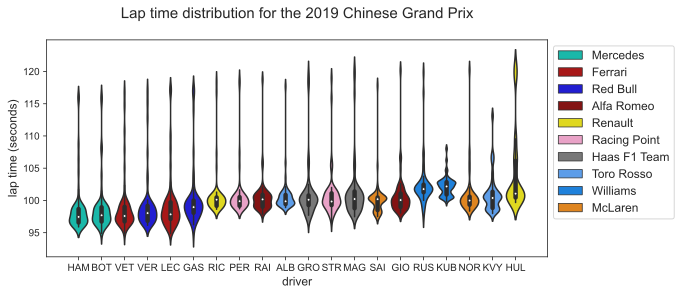

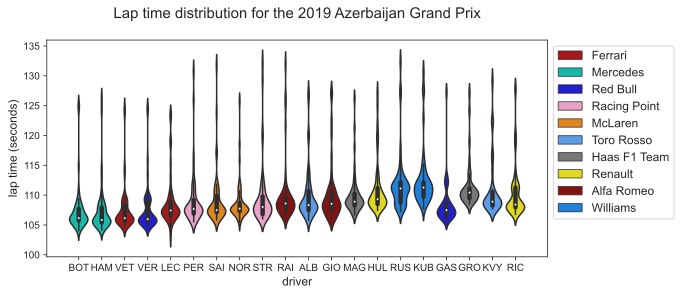

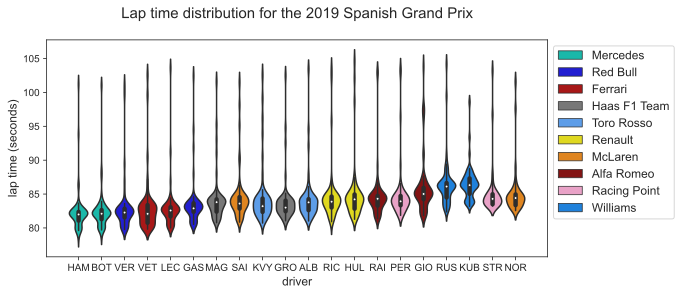

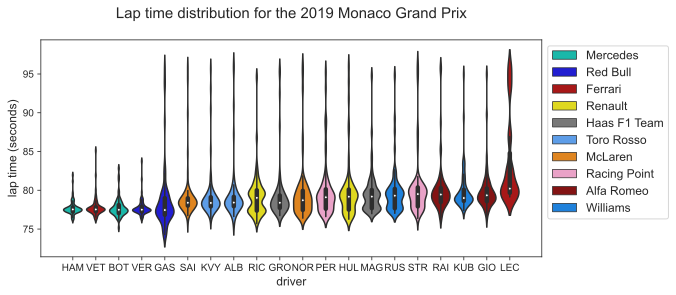

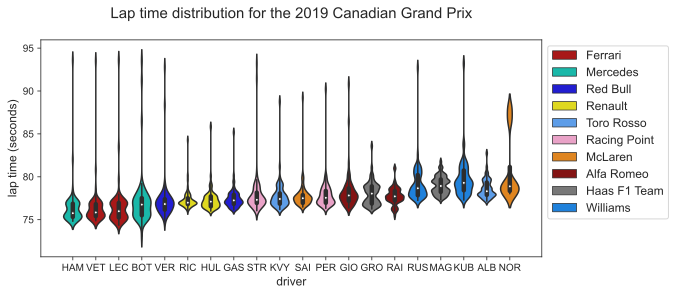

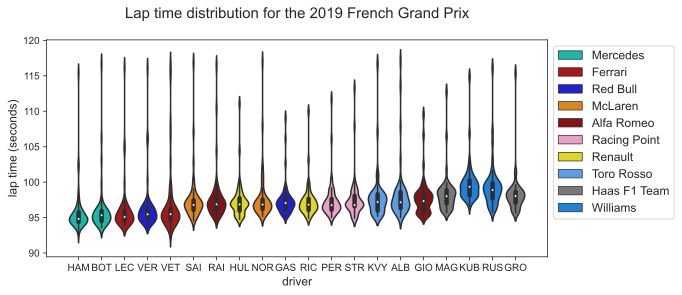

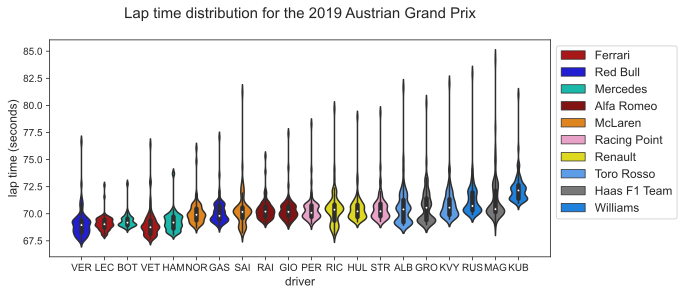

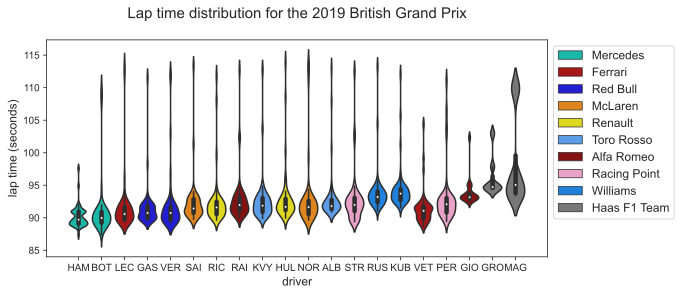

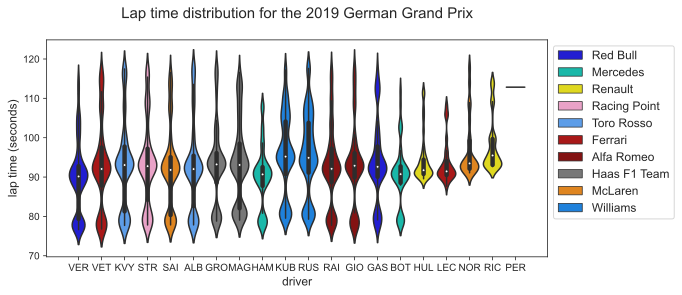

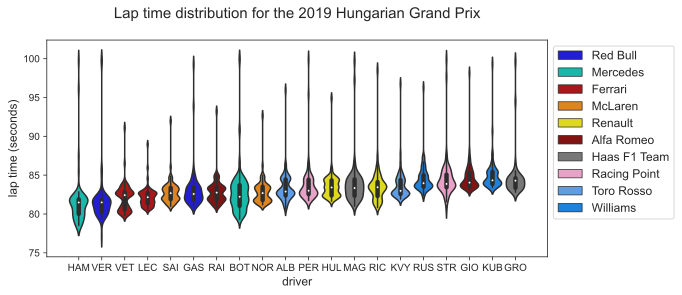

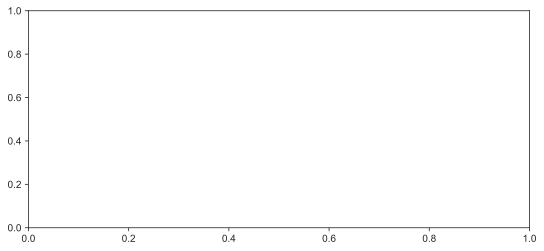

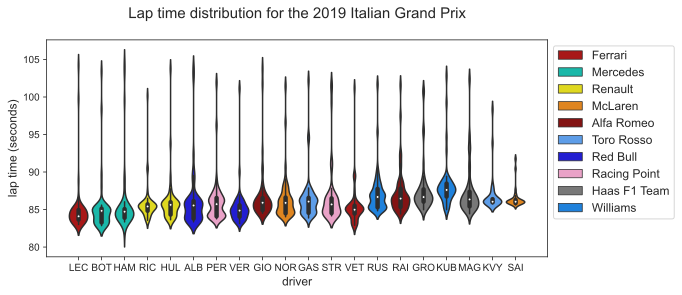

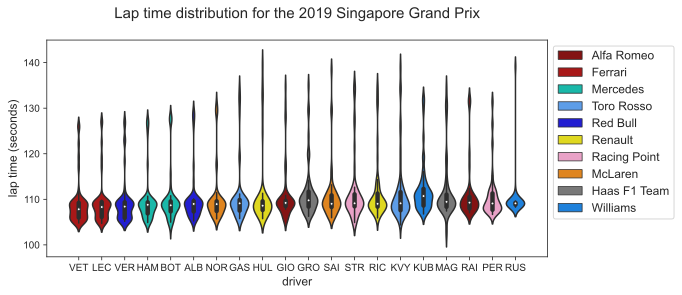

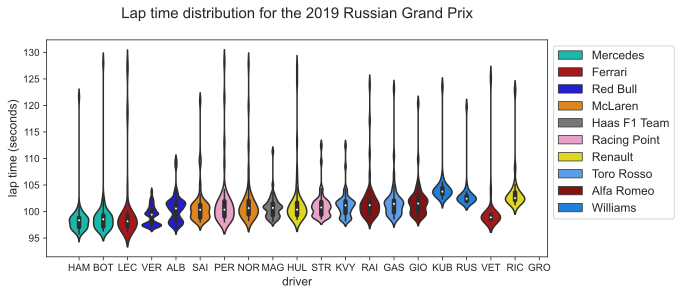

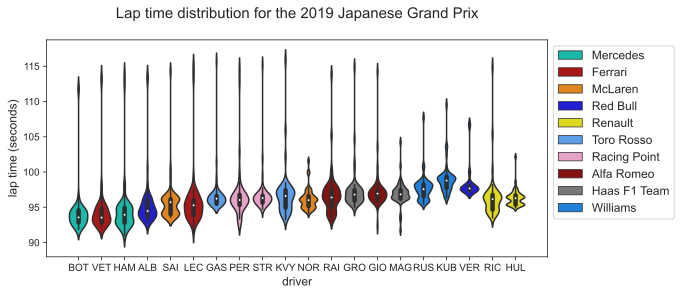

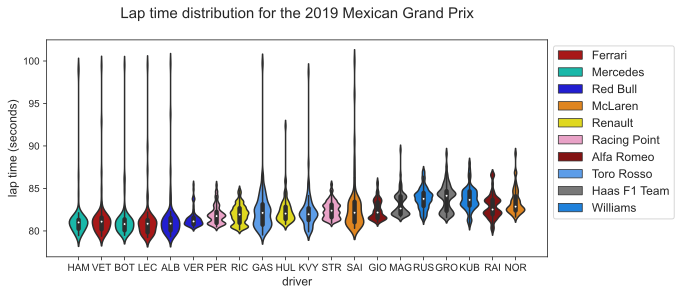

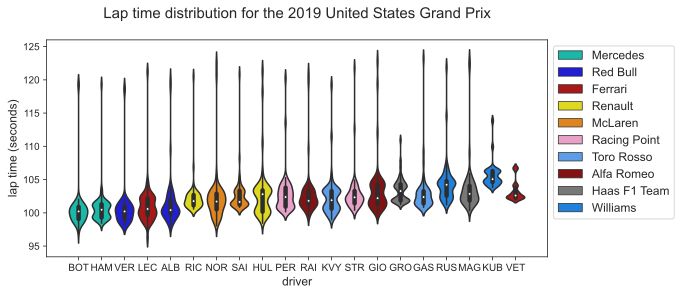

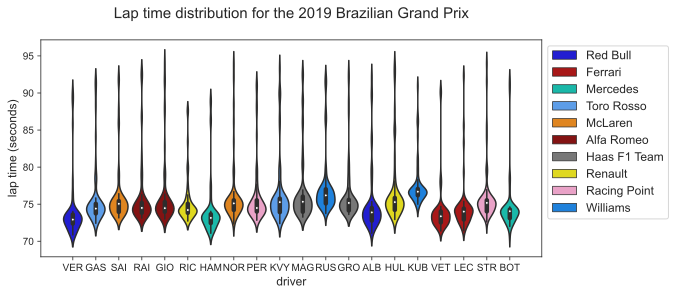

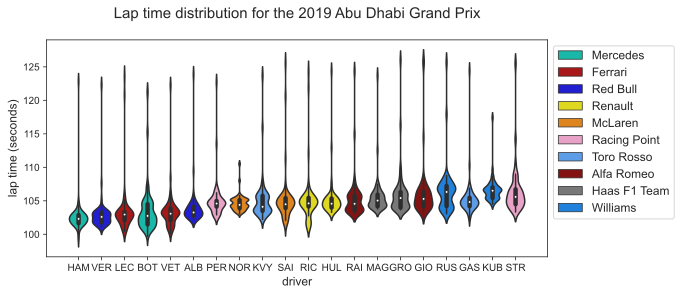

In [308]:
df3 = plot_all_races(2019, cutoff=1.2, outliers=True)

TODO: 
- Look into the anomalous results in several races (Japanese Grand Prix, Belgian Grand Prix, & German Grand Prix)

# 2.2 Coefficients of variation over the course of a season

## Consistency over the course of a season

While drivers may make mistakes during the race, one way to judge the overall consistency of a driver is to calculate the variation in lap times over the course of a season. To remove the effects of lap times changing by circuit, we calculate the coefficient of variation, $c_v = \frac{\sigma}{\mu}$ ($\sigma$ = standard deviation, $\mu$ = average) for each race and investigate the distribution of these variations. 

In [28]:
def get_season_finishing_order(year): 
    
    results_text = f"""
    SELECT driver_standings.position, driver_standings.points, drivers.code, drivers.forename, drivers.surname
    FROM driver_standings
    JOIN drivers ON drivers.driverid = driver_standings.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year} AND races.round = (SELECT MAX(races.round) FROM races WHERE races.year = {year})
    """
    results_df = query(results_text).sort_values(by='points', ascending=False);
    return results_df

In [29]:
def calc_variations(year=2020, plot=True, team_abbrev=team_abbrev, bw=.15): 
    """Plot the distrubution of lap time variations for each driver over the course of a season.
    
    Parameters
    -------
    year: selected year (2020 default)
    plot: if true, plots are automatically generated, if false, only calculated data frames are returned
    team_abbrev: dictionary of team abbreviations. In the case of mid season driver changes (e.g. Pierre Gasly and 
        Alex Albon's swap in 2019), the lap time distribution is segregated between each team and the team abbreviation
        is appended to the driver code for better discernment. 
    
    Returns
    -------
    df: merged DataFrame containing the race variation info and season results
    season_results: DataFrame containing the standings at the end of the selected season
    race_data: DataFrame with the coefficient of variation for each race for each driver
    Axes: array with the 2 axis handles for each plot (only returned if plot is True)
    """
    
    races_query = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """
    
    drivers_query = f"""
    SELECT DISTINCT drivers.code
    FROM drivers
    JOIN driver_standings ON driver_standings.driverid = drivers.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = {year}
    """
    # set font sizes for axes
    LARGE_FONT = 18
    MED_FONT   = 12
    SMALL_FONT = 9
    
    # get all the races in a single season
    races = query(races_query)['name'].to_numpy() 
    
    # get the drivers for a given season
    drivers = query(drivers_query)['code'].to_numpy()             
    
    # initialize a dataframe for the coefficients of variation in every race
    race_data = pd.DataFrame(columns = ['race', 'driver', 'team',  'coef_of_var'])
    
    # get the final season standings
    season_results = get_season_finishing_order(year)

    # loop through each race and calculate the coefficient of variation for each driver
    for race in races: 
        
        # since the 2020 season isn't over there will be some races that don't have any data
        try:
            race_dist = get_race_distribution(race, year) 
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
            
        # loop through each driver
        for driver in drivers: 
            
            laps = race_dist['lap_time'][race_dist['code']==driver].values
            
            # filter non-finishers
            if len(laps) == 0: 
                continue
            
            # get average, standard deviation, and team
            avg  = np.average(laps)
            sd   = np.std(laps)
            team = race_dist['team'][race_dist['code'] == driver].values[0]
              
            # append to dataframe
            race_data = race_data.append({'race'       : race,
                                          'driver'     : driver, 
                                          'team'       : team, 
                                          'coef_of_var': sd/avg}, 
                                           ignore_index=True)
            
    # merge the race data and season results to properly order the drivers
    df = pd.merge(race_data, season_results, left_on='driver', right_on='code')


    # handle mid-season driver switches
    # add team abbreviation to driver code if they drove for multiple teams in the same season
    for driver in df['driver']: 
        if len(df['team'][df['driver']==driver].unique())>1: 
            for team in df['team'][df['driver']==driver].unique(): 
                df['driver'][(df['driver']==driver) & 
                             (df['team']==team)] = f"{driver}\n({team_abbrev[team]})"
               
     # return the dataframes if we're not plotting anything
    if plot == False: 
         return df, season_results, race_data
        
#     # make box plots, order by drivers standings
    fig, ax = plt.subplots(nrows=2, figsize=[10,10])
    
    plt.subplots_adjust(hspace=0.5)
    sns.violinplot(data=df, 
                   x='driver',
                   #x=df['driver'], 
                   y='coef_of_var', 
                   ax=ax[0], 
                   hue='team', 
                   palette=colors, 
                   #whis=1.5,
                   dodge=False,
                   bw=bw, 
                   order=df.sort_values(by='points', ascending=False)['driver'].unique()
                   )

    ax[0].set_title(f"\nCoefficient of variation distributions for the {year} season, ordered by driver standings\n", 
                    fontsize=LARGE_FONT)
    

    # order by average coefficient of variation
    order_var = pd.DataFrame(columns = ['driver', 'avg_coef_of_var'])
    
    for driver in df['driver'].unique(): 
        avg_var = np.nanmean(df['coef_of_var'][df['driver']==driver])
        order_var = order_var.append({'driver': driver, 'avg_coef_of_var': avg_var}, ignore_index=True)

    sns.violinplot(data=df, 
                x=df['driver'], 
                #x = 'driver', 
                y='coef_of_var', 
                ax=ax[1], 
                hue='team', 
                palette=colors, 
                #whis=1.5,
                dodge=False,
                bw=bw,
                order=order_var.sort_values(by='avg_coef_of_var')['driver'].to_numpy()
               )

    ax[1].set_title(f"\nCoefficient of variation distributions for the {year} season, ordered by lowest average variation\n",
                    fontsize = LARGE_FONT)
    
    # format axes
    for i in [0,1]:
        ax[i].set_xlabel("driver\n",                 fontsize=MED_FONT)
        ax[i].set_ylabel("coefficient of variation", fontsize=MED_FONT)
        ax[i].tick_params(axis='x',                  labelsize=SMALL_FONT)
        ax[i].tick_params(axis='y',                  labelsize=SMALL_FONT)
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=MED_FONT)
    return df, season_results, race_data, [ax[0], ax[1]]

<ipython-input-29-7c4a29d2b2cb>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driver'][(df['driver']==driver) &


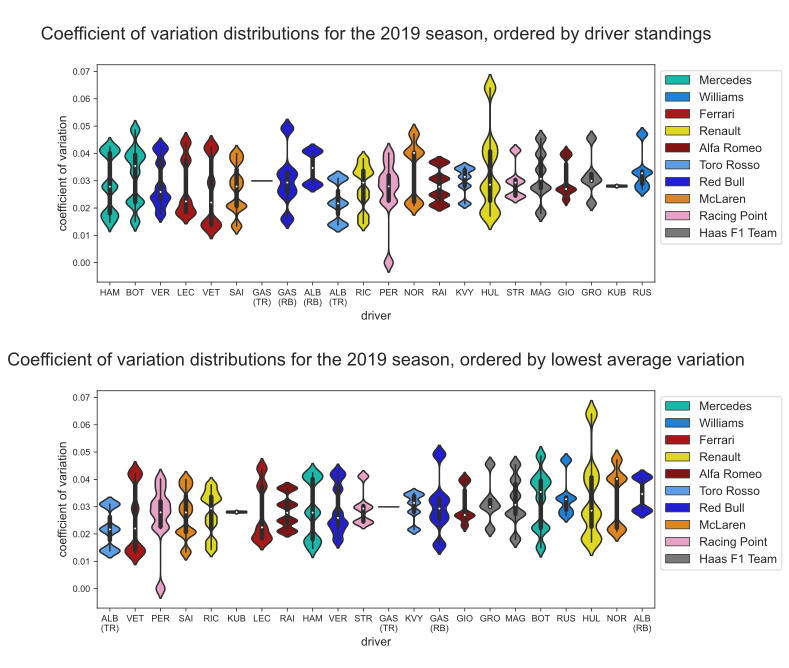

In [30]:
df, season_results, race_data, axes = calc_variations(year=2019, plot=True)

It appears that Robert Kubica (KUB) has the lowest average variation in lap times, with Hamilton a close second. These distributions are very close, so it's likely that we won't be able to difinitively say who is the most consistent driver based on the metrics chosen. Aditionally, Sergio Perez (PER) seems to have one race with a coefficient of variation of zero. As this is impossible, it is likely that more refinement needs to be done to filter the lap times properly. 

# 3. Finishing position vs. grid position

Another way to measure the relative quality between drivers is their average start vs. average finishing position. 

List of metrics to look at: 
a
- distribution of starting positions
- distribution of finishing positions
- distribution of positions gained / lost over a race

Write a query to get the race results

In [201]:
def get_results(race=None, year=None): 
    text = f"""
    SELECT drivers.forename, 
           drivers.surname,
           drivers.code, 
           constructors.name AS team, 
           races.name,
           results.grid, 
           results.position, 
           results.positiontext, 
           results.points, 
           results.laps, 
           results.fastestlap, 
           results.fastestlaptime, 
           status.status
            
    FROM RESULTS
    
    JOIN drivers ON results.driverid = drivers.driverid
    JOIN races ON results.raceid = races.raceid
    JOIN status ON results.statusid = status.statusid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = {year} AND races.name iLike '%{race}%'
    """
    return query(text)

def get_season_results(year=None): 
    text = f"""
    SELECT races.name
    FROM races
    WHERE races.year = {year}
    """
    
    races = query(text).to_numpy()
    df = pd.DataFrame()
    for race in races: 
        df = df.append(get_results(race=race[0], year=year))
    return df

In [202]:
df = get_season_results(2019)

In [203]:
len(df)

420

Plot starting position, finishing position, and finishing position - starting position as violin plots

In [206]:
df.head()

forename     surname code      team                   name  grid  \
0   Valtteri      Bottas  BOT  Mercedes  Australian Grand Prix     2   
1      Lewis    Hamilton  HAM  Mercedes  Australian Grand Prix     1   
2        Max  Verstappen  VER  Red Bull  Australian Grand Prix     4   
3  Sebastian      Vettel  VET   Ferrari  Australian Grand Prix     3   
4    Charles     Leclerc  LEC   Ferrari  Australian Grand Prix     5   

   position positiontext points  laps  fastestlap   fastestlaptime    status  
0       1.0            1     26    58        57.0  00:01:25.580000  Finished  
1       2.0            2     18    58        57.0  00:01:26.057000  Finished  
2       3.0            3     15    58        57.0  00:01:26.256000  Finished  
3       4.0            4     12    58        16.0  00:01:27.954000  Finished  
4       5.0            5     10    58        58.0  00:01:26.926000  Finished

<AxesSubplot:xlabel='code'>

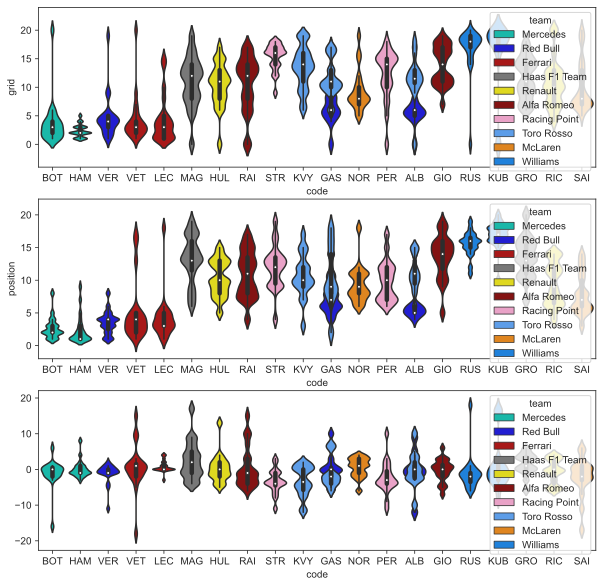

In [217]:
# TODO: account for team changes

fig, ax = plt.subplots(nrows=3, figsize=[10, 10])

sns.violinplot(x=df['code'], 
               y=df['grid'], 
               ax=ax[0],
               dodge=False, 
               bw=.2,
              hue=df['team'], 
                palette=colors,)
sns.violinplot(x=df['code'], 
               y=df['position'], 
               ax=ax[1],
               dodge=False, 
               bw=.2,
              hue=df['team'], 
                palette=colors,)
sns.violinplot(x=df['code'], 
               y=df['position'] - df['grid'], 
               ax=ax[2],
               dodge=False, 
               bw=.2,
               hue=df['team'], 
               palette=colors,) 
    

# 4. Retirements
Look at which driver had which kind of retirements

In [219]:
df.head()

forename     surname code      team                   name  grid  \
0   Valtteri      Bottas  BOT  Mercedes  Australian Grand Prix     2   
1      Lewis    Hamilton  HAM  Mercedes  Australian Grand Prix     1   
2        Max  Verstappen  VER  Red Bull  Australian Grand Prix     4   
3  Sebastian      Vettel  VET   Ferrari  Australian Grand Prix     3   
4    Charles     Leclerc  LEC   Ferrari  Australian Grand Prix     5   

   position positiontext points  laps  fastestlap   fastestlaptime    status  
0       1.0            1     26    58        57.0  00:01:25.580000  Finished  
1       2.0            2     18    58        57.0  00:01:26.057000  Finished  
2       3.0            3     15    58        57.0  00:01:26.256000  Finished  
3       4.0            4     12    58        16.0  00:01:27.954000  Finished  
4       5.0            5     10    58        58.0  00:01:26.926000  Finished

In [220]:
df['status'].unique()

array(['Finished', '+1 Lap', '+2 Laps', '+3 Laps', 'Wheel', 'Damage',
       'Engine', 'Out of fuel', 'Collision damage', 'Retired',
       'Collision', 'Power Unit', 'Transmission', 'Brakes', 'Suspension',
       'Spun off', 'Accident', 'Power loss', 'Exhaust', 'Water pressure',
       'Hydraulics', 'Disqualified', 'Overheating', 'Withdrew',
       'Oil leak'], dtype=object)

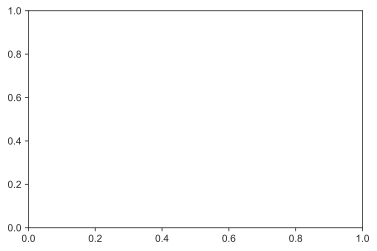

In [221]:
mechanical_dnf = ["Wheel", "Engine", "Out of Fuel", "Power Unit", "Transmission", "Brakes", "Suspension", "Power loss", 
                 "Exhaust", "Water pressure", "Hydraulics", "Overheating", "Oil leak"]

crash_dnf = ["Damage", "Collision damage", "Retired", "Collision", "Spun off", "Accident", "Disqualified", "Withdrew"]


fig, ax = plt.subplots()

sns.boxpplot()